In [1]:
import numpy as np
from matplotlib import pyplot as plt
import time

In [2]:
class CalcSumAndTime:
  def __init__(self, sum_func, num_elems, val, step=None, name="Unnamed algorithm"):
    self._sum_func = sum_func
    self._num_elems = num_elems
    self._val = val
    self._arr = np.array([val for _ in range(num_elems)])
    self._name = name

    self._sum = None
    self._calc_raport = None
    self._err_raport = None
    self._step = step

  def get_sum(self):
    if self._sum is None:
      self._sum, self._calc_raport = self._sum_func(arr=self._arr, step=self._step)
    return self._sum
  
  def get_avg(self):
    return self.get_sum() / self._num_elems
  
  def get_abs_err(self):
    return np.single(abs(self.get_sum() - self._val*self._num_elems))
  
  def get_rel_err(self):
    return self.get_abs_err() / (self._val*self._num_elems)
  
  def get_text_result(self):
    return  f'v = {self._val} \n' \
            f'avg = {self.get_avg()} \n' \
            f'abs_err = {self.get_abs_err()} \n' \
            f'rel_err = {format(100*self.get_rel_err(), ".2f")}%'
  
  def get_err_raport(self):
    if self._step is None: return None

    if self._err_raport is None:
      if self._calc_raport is None:
        self._sum, self._calc_raport = self._sum_func(
          arr=self._arr, step=self._step
        )
      
      self._err_raport = []
      for i in range(len(self._calc_raport)):
        actual_val = (i+1)*self._step*self._val
        self._err_raport.append(
          abs(self._calc_raport[i] - actual_val) / actual_val
        )
    
    return self._err_raport
  
  def present(self):
    start_time = time.time()
    print(f'{self._name}:')
    print(self.get_text_result())
    end_time = time.time()
    print(f'\nTime elapsed: {format(end_time - start_time, ".2f")} seconds \n\n')

Naive algorithm:
v = 0.53125 
avg = 0.50308405 
abs_err = 281659.5 
rel_err = 5.30%

Time elapsed: 1.23 seconds 


Recursive algorithm:
v = 0.53125 
avg = 0.53125 
abs_err = 0.0 
rel_err = 0.00%

Time elapsed: 7.49 seconds 




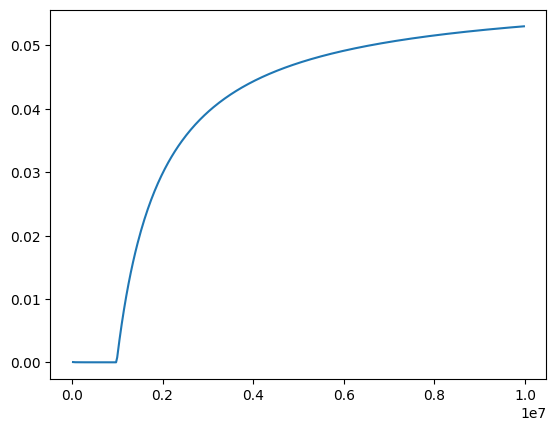

In [3]:
def naive_sum(arr, step=None):
  result = np.single(0)
  result_raport = []

  i = 0
  for elem in arr:
    result += elem
    if step is not None and i >= step:
      result_raport.append(result)
      i-=step
    i += 1

  return result, result_raport

def recursive_sum(arr, first=0, last=None, step=None):
  if last is None: last = len(arr)-1

  if first == last:
    return arr[first], None
  
  mid = first + (last - first) // 2
  return np.single(
    recursive_sum(arr, first=first, last=mid)[0] + \
    recursive_sum(arr, first=mid + 1, last=last)[0]
  ), None

n = 10**7
v = np.single(0.53125)
s = 25_000

naive_calc = CalcSumAndTime(naive_sum, n, v, s, "Naive algorithm")

recursive_calc = CalcSumAndTime(recursive_sum, n, v, s, "Recursive algorithm")

naive_calc.present()
recursive_calc.present()

plt.plot([i for i in range(s,n,s)], naive_calc.get_err_raport())
plt.show()

In [4]:
def kahan_sum(arr, step=None):
  result = np.single(0)
  error = np.single(0)

  for el in arr:
    y = np.single(el - error)
    temp = np.single(result + y)
    error = np.single(
        np.single(temp - result) - y
    )
    result = temp

  return result, None

n = 10**7
v = np.single(0.53125)

naive_calc = CalcSumAndTime(naive_sum, n, v, name="Naive algorithm")
kahan_calc = CalcSumAndTime(kahan_sum, n, v, name="Kahan algorithm")

naive_calc.present()
kahan_calc.present()

Naive algorithm:
v = 0.53125 
avg = 0.50308405 
abs_err = 281659.5 
rel_err = 5.30%

Time elapsed: 1.12 seconds 


Kahan algorithm:
v = 0.53125 
avg = 0.53125 
abs_err = 0.0 
rel_err = 0.00%

Time elapsed: 13.54 seconds 




In [5]:
class Series:
  def __init__(self, function, s, n, precision_type=np.single):
    self._function = function
    self._s = s
    self._n = n
    self._precision_type = precision_type

  def _claculate(self, forward=True):
    result = self._precision_type(0)
    start, stop, step = (1, self._n, 1) if forward else (self._n, 0, -1)
    for i in range(start, stop, step):
      result += self._function(k=i, s=self._s)

    return result
  
  def calculate_forward(self):
    return self._claculate(forward=True)
  
  def calculate_backward(self):
    return self._claculate(forward=False)


def dzeta(k, s):
  return 1 / (k**s)

def eta(k, s):
  return (-1)**(k-1) / (k**s)

s_list = [2, 3.6667, 5, 7.2, 10]
n_list = [50, 100, 200, 500, 1_000]

print("Single precision:")

for (f, function_name) in [(dzeta, "Riemann's Dzeta"), (eta, "Dirichlet's Eta")]:
  for s in s_list:
    for n in n_list:
      for is_forward in [True, False]:
        series = Series(f,s,n)
        print(f'function: {function_name} \n'
              f's = {s} \n'
              f'n = {n} \n'
              f'direction = {"Forward" if is_forward else "Backward"} \n'
              f'result = {series.calculate_forward() if is_forward else series.calculate_backward()} \n\n'
        )

Single precision:
function: Riemann's Dzeta 
s = 2 
n = 50 
direction = Forward 
result = 1.6247327336215291 


function: Riemann's Dzeta 
s = 2 
n = 50 
direction = Backward 
result = 1.6251327336215293 


function: Riemann's Dzeta 
s = 2 
n = 100 
direction = Forward 
result = 1.6348839001848923 


function: Riemann's Dzeta 
s = 2 
n = 100 
direction = Backward 
result = 1.634983900184893 


function: Riemann's Dzeta 
s = 2 
n = 200 
direction = Forward 
result = 1.6399215460149972 


function: Riemann's Dzeta 
s = 2 
n = 200 
direction = Backward 
result = 1.6399465460149973 


function: Riemann's Dzeta 
s = 2 
n = 500 
direction = Forward 
result = 1.642932065514894 


function: Riemann's Dzeta 
s = 2 
n = 500 
direction = Backward 
result = 1.6429360655148941 


function: Riemann's Dzeta 
s = 2 
n = 1000 
direction = Forward 
result = 1.6439335666815615 


function: Riemann's Dzeta 
s = 2 
n = 1000 
direction = Backward 
result = 1.6439345666815597 


function: Riemann's Dzeta 
s 

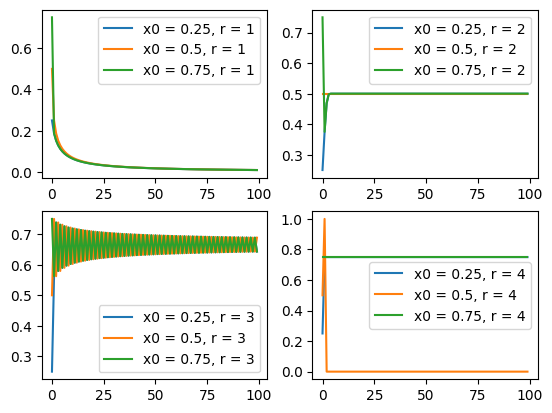

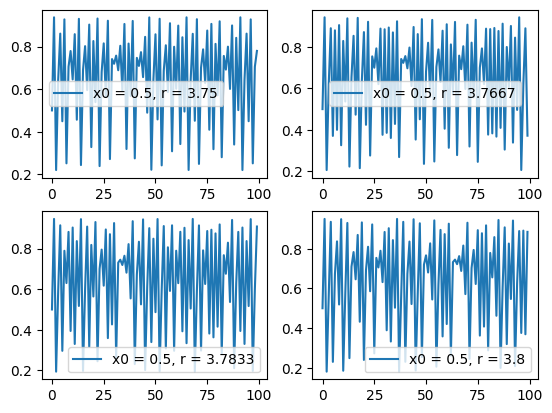

In [6]:
def logistic_map_generate_n(x0, r, n, data_type=np.single):
  def x_next(x_prev):
    return r * x_prev * (1 - x_prev)

  results = np.zeros(shape=n, dtype=data_type)
  results[0] = x0

  for i in range(1, n):
    results[i] = x_next(results[i-1])

  return results


def plot(r_list, x0_list, n, save_as=None):
  legend = []
  figure, axis = plt.subplots(2, 2)

  i = 0
  for r in r_list:
    legend.append([])
    for x0 in x0_list:
        y = logistic_map_generate_n(x0=x0, r=r, n=n)
        axis[i // 2][i % 2].plot([i for i in range(N)], y)
        legend[-1].append(f'x0 = {x0}, r = {r}')
    axis[i // 2][i % 2].legend(legend[-1])
    i += 1

  if save_as is not None:
    plt.savefig(save_as, dpi=1200)
  plt.show()


N = 100

plot(
    r_list = [1, 2, 3, 4],
    x0_list = [0.25, 0.5, 0.75],
    n = N
)

plot(
    r_list = [3.75, 3.7667, 3.7833, 3.8],
    x0_list = [0.5],
    n = N
)